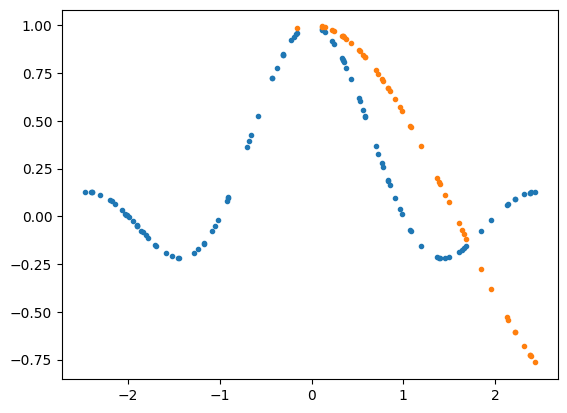

In [93]:
from matplotlib import pyplot as plt
import numpy as np
import torch


# Define the activation functions
def sin_activation(x):
    return np.sin(x)

def square_activation(x):
    return x**2

def bent_activation(x):
    return (np.sqrt(x ** 2 + 1) - 1) / 2 + x

def cos_activation(x):
    return np.cos(x)

def sinc_activation(x):
    return np.sinc(x)

# task_list = [
#     sin_activation,
#     square_activation,
#     bent_activation,
#     cos_activation,
#     sinc_activation,
# ]

task_list = [
    sinc_activation,
    cos_activation,
]

input_dim = 1
extrapolate = True
full_tasks = [0]

# generate data
np.random.seed(0)
x_train = (np.random.rand(100, input_dim) - 0.5) * 5.0
x_valid = (np.random.rand(100, input_dim) - 0.5) * 5.0

delta_mag = 0.0

y_train = np.zeros([x_train.shape[0], 0])
y_valid = np.zeros([x_valid.shape[0], 0])
for task in task_list:
    y_train = np.hstack([y_train, task(x_train) + np.random.randn(x_train.shape[0], x_train.shape[1]) * delta_mag])
    y_valid = np.hstack([y_valid, task(x_valid) + np.random.randn(x_valid.shape[0], x_valid.shape[1]) * delta_mag])

missing_frac = 0.5
for i, _ in enumerate(task_list):
    if extrapolate:
        if np.random.rand() < 0.5:
            lo_pct = 0  # start at left boundary
        else:
            lo_pct = 1 - missing_frac  # start at right boundary
    else:
        lo_pct = np.random.rand() * (1-missing_frac)
    hi_pct = lo_pct + missing_frac
    lo, hi = np.percentile(x_train, [lo_pct*100, hi_pct*100])
    x_in = (x_train >= lo) & (x_train <= hi)
    if i in full_tasks:
        x_in = np.zeros(0, dtype=bool)
    y_train[x_in.flatten(), i] = np.nan

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

for i in range(y_train.shape[1]):
    plt.plot(x_train, y_train[:, i], '.')

In [94]:
from torch import nn, optim
import sparsenn

input_dim = x_train.shape[1]
hidden_dim = (16, 16, 16, )
output_dim = y_train.shape[1]

model = sparsenn.RegularizedMLPwithSkips(input_dim, hidden_dim, output_dim, activation=nn.ReLU())
criterion = sparsenn.MultiTaskMSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [95]:
from sparsenn import pareto

explored_values = []
frontier = []

max_epochs = int(1e6)

lmbda_reg = 1e-5
reg_prec = 3
patience_interval = 1000
last_best = 0
model.train()
for epoch in range(max_epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    reg_loss = model.regularization_loss()
    total_loss = loss + lmbda_reg * reg_loss
    total_loss.backward()
    optimizer.step()

    point = np.array([loss.item(), np.round(reg_loss.item(), reg_prec)])
    explored_values.append(point)
    if not pareto.is_dominated(point, frontier):
        frontier = pareto.update_pareto_front(point, frontier)
        last_best = epoch

    if reg_loss.item() < 1:
        break

    if (epoch+1) % 1000 == 0:
        with torch.no_grad():
            outputs = model(x_valid)
            valid_loss = criterion(outputs, y_valid)
        print(f'Epoch {epoch+1}, MSE: {loss.item():.4f}, L0R: {reg_loss.item():.2f}, ValMSE: {valid_loss.item():.4f}')
    
    if epoch - last_best > patience_interval:
        print('Patience expired...')
        break

Epoch 1000, MSE: 0.0058, L0R: 371.68, ValMSE: 0.1666
Epoch 2000, MSE: 0.0040, L0R: 347.49, ValMSE: 0.1975
Epoch 3000, MSE: 0.0027, L0R: 325.93, ValMSE: 0.2798
Epoch 4000, MSE: 0.0009, L0R: 300.79, ValMSE: 0.2844
Epoch 5000, MSE: 0.0008, L0R: 271.15, ValMSE: 0.3087
Epoch 6000, MSE: 0.0028, L0R: 237.75, ValMSE: 0.2620
Epoch 7000, MSE: 0.0005, L0R: 202.36, ValMSE: 0.1677
Epoch 8000, MSE: 0.0003, L0R: 168.26, ValMSE: 0.2286
Epoch 9000, MSE: 0.0002, L0R: 139.97, ValMSE: 0.1916
Epoch 10000, MSE: 0.0002, L0R: 120.51, ValMSE: 0.1113
Epoch 11000, MSE: 0.0003, L0R: 106.19, ValMSE: 0.1961
Epoch 12000, MSE: 0.0001, L0R: 93.79, ValMSE: 0.2034
Epoch 13000, MSE: 0.0009, L0R: 83.98, ValMSE: 0.1840
Epoch 14000, MSE: 0.0001, L0R: 75.02, ValMSE: 0.1677
Epoch 15000, MSE: 0.0021, L0R: 68.42, ValMSE: 0.1663
Epoch 16000, MSE: 0.0002, L0R: 65.06, ValMSE: 0.1387
Epoch 17000, MSE: 0.0001, L0R: 61.51, ValMSE: 0.1181
Epoch 18000, MSE: 0.0001, L0R: 59.27, ValMSE: 0.1228
Epoch 19000, MSE: 0.0007, L0R: 56.28, ValMSE

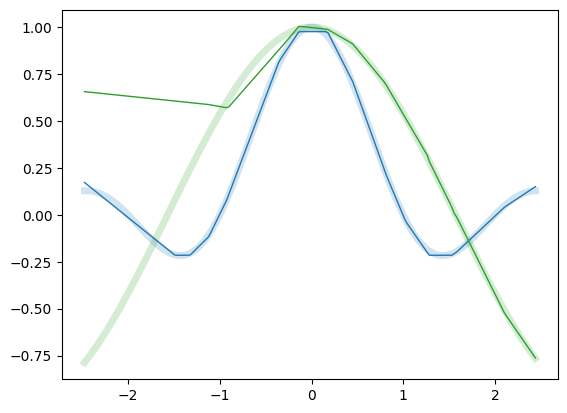

In [96]:
from matplotlib import cm

mt_model = model
mt_model.eval()

fig, ax = plt.subplots()

x_arr = torch.linspace(x_train.min(), x_train.max(), 201)
with torch.no_grad():
    output = mt_model(x_arr.unsqueeze(1))
idx = np.argsort(x_train.numpy().flatten())
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:pink']
# colors = cm.viridis(np.hstack([np.linspace(0, 0.25, 5), np.linspace(0.375, 0.625, 5), np.linspace(0.75, 1.0, 5)]))
# colors = cm.viridis(np.linspace(0, 1, y_train.shape[1]))
for i in range(y_train.shape[1]):
    ax.plot(x_arr, task_list[i](x_arr), '-', c=colors[i], lw=5, alpha=0.2, zorder=0)
    # ax.plot(x_train[idx], y_train[idx, i], '.', c=colors[i], alpha=0.33)
    ax.plot(x_arr, output.numpy()[:, i], '-', c=colors[i], lw=1.0, zorder=1)

In [97]:
# train the single task models
st_models = []
for i, t in enumerate(task_list):
    # setup
    model = sparsenn.RegularizedMLPwithSkips(input_dim, hidden_dim, 1, activation=nn.ReLU())
    criterion = sparsenn.MultiTaskMSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    
    # train
    explored_values = []
    frontier = []
    
    max_epochs = int(1e6)
    
    lmbda_reg = 1e-5
    reg_prec = 3
    patience_interval = 1000
    last_best = 0
    model.train()
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train[:, [i]])
        reg_loss = model.regularization_loss()
        total_loss = loss + lmbda_reg * reg_loss
        total_loss.backward()
        optimizer.step()
    
        point = np.array([loss.item(), np.round(reg_loss.item(), reg_prec)])
        explored_values.append(point)
        if not pareto.is_dominated(point, frontier):
            frontier = pareto.update_pareto_front(point, frontier)
            last_best = epoch
    
        if reg_loss.item() < 1:
            break
    
        if (epoch+1) % 1000 == 0:
            with torch.no_grad():
                outputs = model(x_valid)
                valid_loss = criterion(outputs, y_valid[:, [i]])
            print(f'Epoch {epoch+1}, MSE: {loss.item():.4f}, L0R: {reg_loss.item():.2f}, ValMSE: {valid_loss.item():.4f}')
        
        if epoch - last_best > patience_interval:
            print('Patience expired...')
            break
    
    st_models.append(model)

Epoch 1000, MSE: 0.0167, L0R: 382.08, ValMSE: 0.0134
Epoch 2000, MSE: 0.0061, L0R: 350.82, ValMSE: 0.0081
Epoch 3000, MSE: 0.0029, L0R: 326.10, ValMSE: 0.0123
Epoch 4000, MSE: 0.0009, L0R: 297.10, ValMSE: 0.0007
Epoch 5000, MSE: 0.0007, L0R: 265.42, ValMSE: 0.0013
Epoch 6000, MSE: 0.0003, L0R: 232.24, ValMSE: 0.0005
Epoch 7000, MSE: 0.0005, L0R: 198.68, ValMSE: 0.0006
Epoch 8000, MSE: 0.0011, L0R: 164.54, ValMSE: 0.0003
Epoch 9000, MSE: 0.0003, L0R: 134.78, ValMSE: 0.0002
Epoch 10000, MSE: 0.0006, L0R: 112.12, ValMSE: 0.0003
Epoch 11000, MSE: 0.0002, L0R: 92.57, ValMSE: 0.0004
Epoch 12000, MSE: 0.0001, L0R: 80.78, ValMSE: 0.0004
Epoch 13000, MSE: 0.0001, L0R: 72.89, ValMSE: 0.0002
Epoch 14000, MSE: 0.0001, L0R: 69.26, ValMSE: 0.0001
Epoch 15000, MSE: 0.0001, L0R: 64.54, ValMSE: 0.0002
Epoch 16000, MSE: 0.0002, L0R: 63.42, ValMSE: 0.0002
Epoch 17000, MSE: 0.0002, L0R: 60.43, ValMSE: 0.0002
Epoch 18000, MSE: 0.0002, L0R: 60.18, ValMSE: 0.0001
Epoch 19000, MSE: 0.0001, L0R: 58.30, ValMSE:

/var/folders/07/n4t05n2n2_l8dd11sbdcnzq80000gq/T/ipykernel_47585/2708832797.py:21: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448804225/work/aten/src/ATen/native/IndexingUtils.h:28.)
  train_domain = np.sort(x_train[np.isfinite(y_train[:, i])].numpy().flatten())
/var/folders/07/n4t05n2n2_l8dd11sbdcnzq80000gq/T/ipykernel_47585/2708832797.py:39: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448804225/work/aten/src/ATen/native/IndexingUtils.h:28.)
  train_domain = np.sort(x_train[np.isfinite(y_train[:, i])].numpy().flatten())


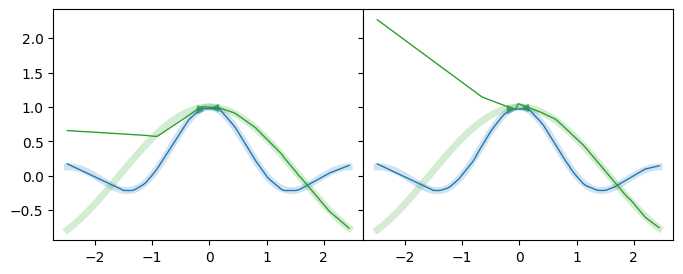

In [98]:
from matplotlib import cm

mt_model.eval()

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey='all')
fig.subplots_adjust(wspace=0)

ax = axes[0]

x_arr = torch.linspace(x_train.min(), x_train.max(), 101)
with torch.no_grad():
    output = mt_model(x_arr.unsqueeze(1))
idx = np.argsort(x_train.numpy().flatten())
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:pink']
# colors = cm.viridis(np.hstack([np.linspace(0, 0.25, 5), np.linspace(0.375, 0.625, 5), np.linspace(0.75, 1.0, 5)]))
# colors = cm.viridis(np.linspace(0, 1, y_train.shape[1]))
for i in range(y_train.shape[1]):
    ax.plot(x_arr, task_list[i](x_arr), '-', c=colors[i], lw=5, alpha=0.2, zorder=0)
    ax.plot(x_arr, output.numpy()[:, i], '-', c=colors[i], lw=1.0, zorder=1)
    # show training domain
    train_domain = np.sort(x_train[np.isfinite(y_train[:, i])].numpy().flatten())
    skip_idx = np.argmax(np.diff(train_domain))
    train_gap = train_domain[[skip_idx, skip_idx+1]]
    ax.plot(train_gap[0], task_list[i](train_gap)[0], '>', c=colors[i], ms=5, alpha=0.5, zorder=2)
    ax.plot(train_gap[1], task_list[i](train_gap)[1], '<', c=colors[i], ms=5, alpha=0.5, zorder=2)

ax = axes[1]

x_arr = torch.linspace(x_train.min(), x_train.max(), 101)
idx = np.argsort(x_train.numpy().flatten())

for i in range(y_train.shape[1]):
    st_models[i].eval()
    with torch.no_grad():
        output = st_models[i](x_arr.unsqueeze(1))
    ax.plot(x_arr, task_list[i](x_arr), '-', c=colors[i], lw=5, alpha=0.2, zorder=0)
    ax.plot(x_arr, output.numpy(), '-', c=colors[i], lw=1.0, zorder=1)
    # show training domain
    train_domain = np.sort(x_train[np.isfinite(y_train[:, i])].numpy().flatten())
    skip_idx = np.argmax(np.diff(train_domain))
    train_gap = train_domain[[skip_idx, skip_idx+1]]
    ax.plot(train_gap[0], task_list[i](train_gap)[0], '>', c=colors[i], ms=5, alpha=0.5, zorder=2)
    ax.plot(train_gap[1], task_list[i](train_gap)[1], '<', c=colors[i], ms=5, alpha=0.5, zorder=2)

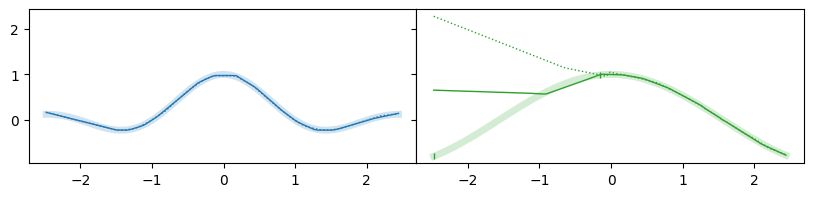

In [103]:
from matplotlib import cm

mt_model.eval()

fig, axes = plt.subplots(1, len(task_list), figsize=(10, 2), sharey='all')
fig.subplots_adjust(wspace=0)


x_arr = torch.linspace(x_train.min(), x_train.max(), 101)

idx = np.argsort(x_train.numpy().flatten())
colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:pink']
# colors = cm.viridis(np.hstack([np.linspace(0, 0.25, 5), np.linspace(0.375, 0.625, 5), np.linspace(0.75, 1.0, 5)]))
# colors = cm.viridis(np.linspace(0, 1, y_train.shape[1]))
for i in range(y_train.shape[1]):
    ax = axes[i]
    
    # do mt model first
    with torch.no_grad():
        mt_output = mt_model(x_arr.unsqueeze(1))
    
    ax.plot(x_arr, task_list[i](x_arr), '-', c=colors[i], lw=5, alpha=0.2, zorder=0)
    ax.plot(x_arr, mt_output.numpy()[:, i], '-', c=colors[i], lw=1.0, zorder=1)
    
    # do st model
    st_models[i].eval()
    with torch.no_grad():
        st_output = st_models[i](x_arr.unsqueeze(1))
    ax.plot(x_arr, st_output.numpy(), ':', c=colors[i], lw=1.0, zorder=2)
    
    # show training domain
    train_domain = np.sort(x_train[np.isfinite(y_train[:, i]).bool()].numpy().flatten())
    train_domain = np.hstack([x_arr.min(), train_domain, x_arr.max()])
    if np.max(np.diff(train_domain)) > 1:
        skip_idx = np.argmax(np.diff(train_domain))
        train_gap = train_domain[[skip_idx, skip_idx+1]]
        ax.plot(train_gap[0], task_list[i](train_gap)[0], '|', c=colors[i], ms=5, alpha=1.0, zorder=3)
        ax.plot(train_gap[1], task_list[i](train_gap)[1], '|', c=colors[i], ms=5, alpha=1.0, zorder=3)

In [100]:
for i, _ in enumerate(task_list):
    with torch.no_grad():
        outputs = mt_model(x_valid)
        valid_loss = criterion(outputs[:, [i]], y_valid[:, [i]])
    print(f'Task {i}: {valid_loss.item():.3e}')
    
print(f'{mt_model.regularization_loss():.0f} total params')

Task 0: 1.020e-04
Task 1: 1.888e-01
39 total params


In [101]:
rl_list = [s.regularization_loss().item() for s in st_models]

for i, _ in enumerate(task_list):
    with torch.no_grad():
        outputs = st_models[i](x_valid)
        valid_loss = criterion(outputs, y_valid[:, [i]])
    print(f'Task {i}: {valid_loss.item():.3e} ({rl_list[i]:.0f} params)')

print(f'{np.sum(rl_list):.0f} total params')

Task 0: 9.886e-05 (33 params)
Task 1: 1.095e+00 (20 params)
53 total params


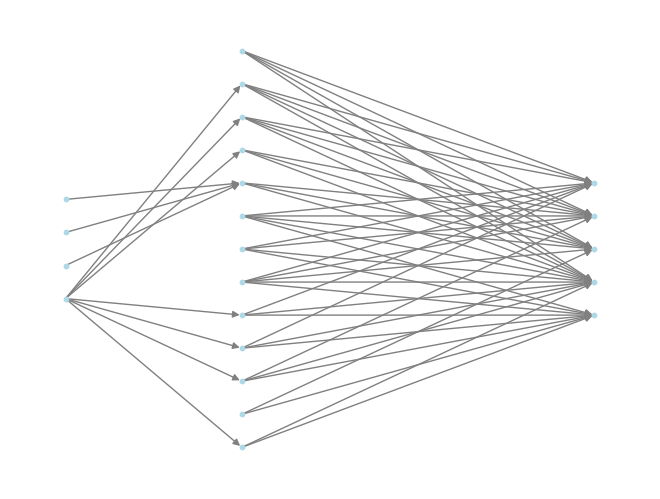

In [99]:
from sparsenn import viz

# Render the optimized architecture 
g = viz.gated_connections_graph(mt_model) 
fig = viz.render_sparse_nn(g)

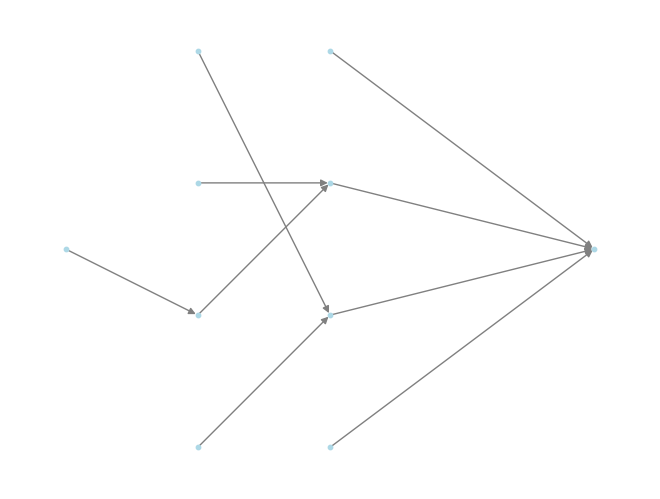

In [105]:
g = viz.gated_connections_graph(st_models[0]) 
fig = viz.render_sparse_nn(g)